# Modéle d'acceptabilité grammaticale d'une phrase

Import des bibliothèques nécessaires et des modèles définis sur les autres fichiers

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import matplotlib.pyplot as plt

from model_1 import MLModel
from model_2 import MLModelNGram
from model_3 import MLModelPosTag
from model_4 import MLModelSentenceRecomposition

On importe les données en lisant le fichier ligne par ligne.
L'import classique a posé des difficultés à cause de la séparation de certaines phrases en 2 colonnes

In [2]:
# Define an empty list to store the data
data = []

# Open the CSV file and read it line by line
with open("Input/data.csv", mode="r", encoding="latin1") as file:
    for line in file:
        parts = line.strip().split(';')
        if len(parts) == 2: 
            if parts[1] == "1":
                parts[1] = 1
            else: 
                parts[1] = 0
            data.append(parts)

df = pd.DataFrame(data, columns=['Sentence', 'Label'])

# Display the DataFrame
df

Sentence  Label
0     Our friends won't buy this analysis, let alone...      1
1     One more pseudo generalization and I'm giving up.      1
2      One more pseudo generalization or I'm giving up.      1
3        The more we study verbs, the crazier they get.      1
4             Day by day the facts are getting murkier.      1
...                                                 ...    ...
8542                   Poseidon appears to own a dragon      0
8543                     Digitize is my happiest memory      0
8544                     It is easy to slay the Gorgon.      1
8545       I had the strangest feeling that I knew you.      1
8546                What all did you get for Christmas?      1

[8547 rows x 2 columns]

# Analyse des données
## 1. Disparité des classes 

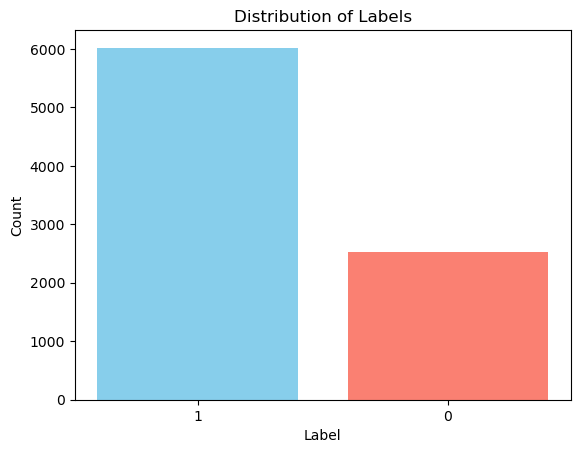

In [3]:
label_counts = df['Label'].value_counts()
plt.bar(label_counts.index.astype(str), label_counts.values, color=['skyblue', 'salmon'])
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Labels')
plt.show()


Il y a une grande disparité des classes entre les phrases correctes et incorrectes. Ceci peut causer un biais au modèle s'il s'entraine sur plus de labels 1 que de 0.
Il faut aussi faire attention à utiliser stratify lorsqu'on sépare les données d'entrainement et de test
## 2. Analyse de la longueur des phrases

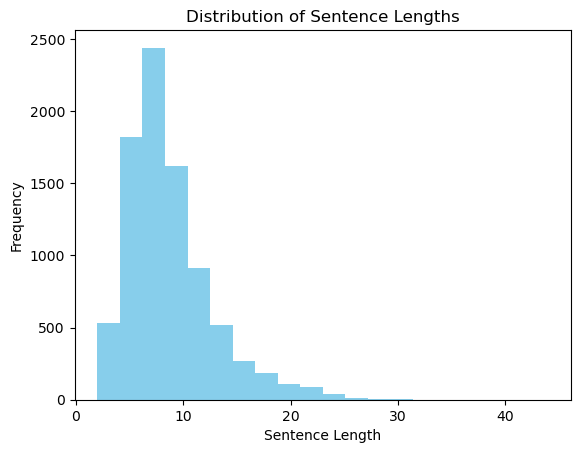

In [4]:
df['Sentence_Length'] = df['Sentence'].apply(lambda x: len(word_tokenize(x)))
plt.hist(df['Sentence_Length'], bins=20, color='skyblue')
plt.xlabel('Sentence Length')
plt.ylabel('Frequency')
plt.title('Distribution of Sentence Lengths')
plt.show()

# 2.1. Word Frequency Analysis


# 2.2 Word Frequency Analysis with Lemmatization



## 3. Analyse de la fréquence des mots

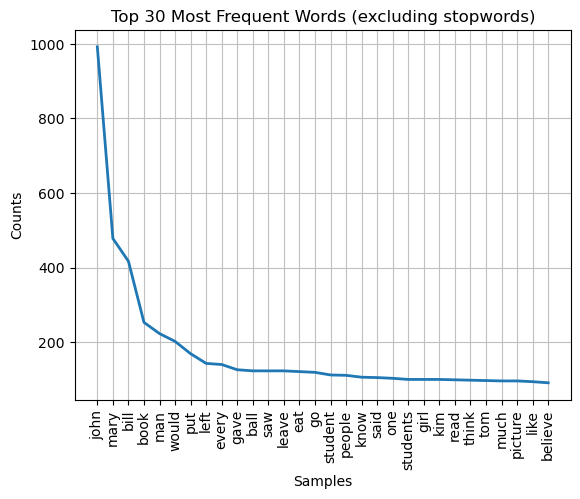

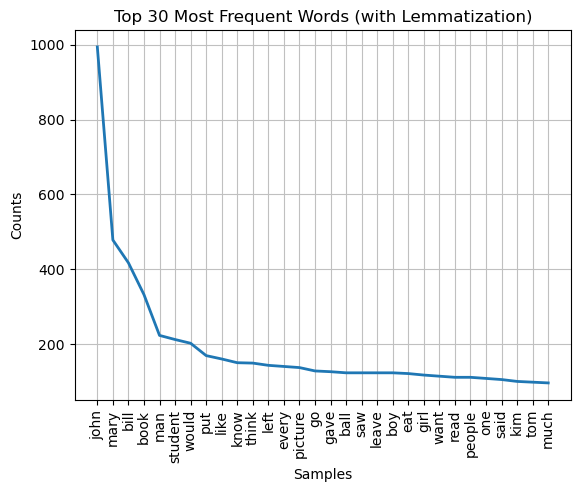

<Axes: title={'center': 'Top 30 Most Frequent Words (with Lemmatization)'}, xlabel='Samples', ylabel='Counts'>

In [5]:
all_words = ' '.join(df['Sentence']).lower()
tokens = word_tokenize(all_words)
words_except_stop_dist = FreqDist(w for w in tokens if w.isalnum() and w.lower() not in stopwords.words('english'))
words_except_stop_dist.plot(30, cumulative=False, title='Top 30 Most Frequent Words (excluding stopwords)')

#avec Lemmatization
lemmatizer = WordNetLemmatizer()
racines = [lemmatizer.lemmatize(t) for t in tokens if t.lower() not in stopwords.words('english')] 
words_except_stop_dist = FreqDist(w for w in racines if w.isalnum())
words_except_stop_dist.plot(30, cumulative=False, title='Top 30 Most Frequent Words (with Lemmatization)')

## 4. Analyse des bigrammes les plus fréquents

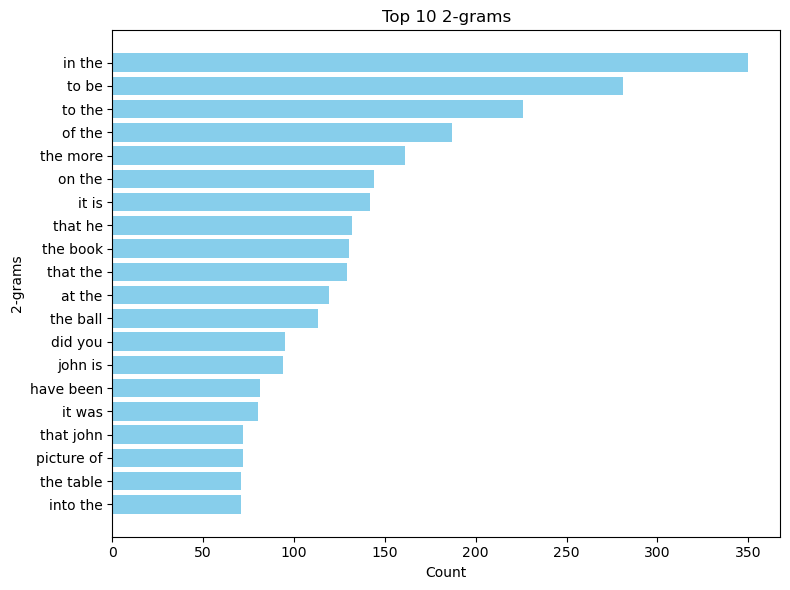

In [6]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer_2grams = CountVectorizer(ngram_range=(2, 2))
X_2grams = vectorizer_2grams.fit_transform(df["Sentence"])
feature_names_2grams = vectorizer_2grams.get_feature_names_out()
counts_2grams = X_2grams.sum(axis=0).A1
df_2grams = pd.DataFrame({'ngram': feature_names_2grams, 'count': counts_2grams})
df_2grams = df_2grams.sort_values(by='count', ascending=False).head(20)  # Adjust to show top 2-grams

plt.figure(figsize=(8, 6))
plt.barh(df_2grams['ngram'], df_2grams['count'], color='skyblue')
plt.xlabel('Count')
plt.ylabel('2-grams')
plt.title('Top 10 2-grams')
plt.gca().invert_yaxis()  # Invert y-axis to show the most frequent n-grams at the top
plt.tight_layout()
plt.show()


# Séparation des données et resampling
On sépare les données en données d'entrainement et données de test

In [7]:
X = df["Sentence"]
y = df["Label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42, stratify=y)

On duplique les phrases incorrectes des données d'entrainement pour éviter un biais à cause de la disparité des classes

In [8]:
df_train = pd.concat([X_train, y_train], axis=1)
df_majority = df_train[df_train["Label"] == 1]
df_minority = df_train[df_train["Label"] == 0]
df_minority_upsampled = resample(df_minority, replace=True, n_samples=len(df_majority), random_state=42)
df_train_upsampled = pd.concat([df_majority, df_minority_upsampled])

    # Separate the oversampled data into X_train and y_train
X_train_upsampled = df_train_upsampled["Sentence"]
y_train_upsampled = df_train_upsampled["Label"]

    # Convert X_train and X_test back to DataFrames
X_train = pd.DataFrame(X_train_upsampled, columns=['Sentence']).reset_index(drop=True)
X_test = pd.DataFrame(X_test, columns=['Sentence']).reset_index(drop=True)
y_train = pd.DataFrame(y_train_upsampled, columns=['Label']).reset_index(drop=True)
y_test = pd.DataFrame(y_test, columns=['Label']).reset_index(drop=True)

# Modèles
On cherche les modèles qui réussissent à identifier les phrases fausses et donc la métrique qui nous intéresse en premier lieu est le recall 
## 1. Modèle ML


Training ...


c:\Users\user\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Train evaluation 

Evaluating ...
bad predictions :
                                                Sentence  Label  Predictions
55    It's probable that in general he understands w...      1            0
76    It was the policeman that met several young st...      1            0
77    It was claimed by everyone that the poison was...      1            0
158      The consul's gift of the gladiator to himself.      1            0
163   The man standing over there's hat impressed me...      1            0
...                                                 ...    ...          ...
8519          The stone knocked the pole into the road.      0            1
9099  the book with a red cover of poems from Blackw...      0            1
9266                      They can't do it, can't they?      0            1
9288         Two drops sanitize anything in your house.      0            1
9559            Speaking not English is a disadvantage.      0            1

[140 rows x 3 columns]
{'accuracy

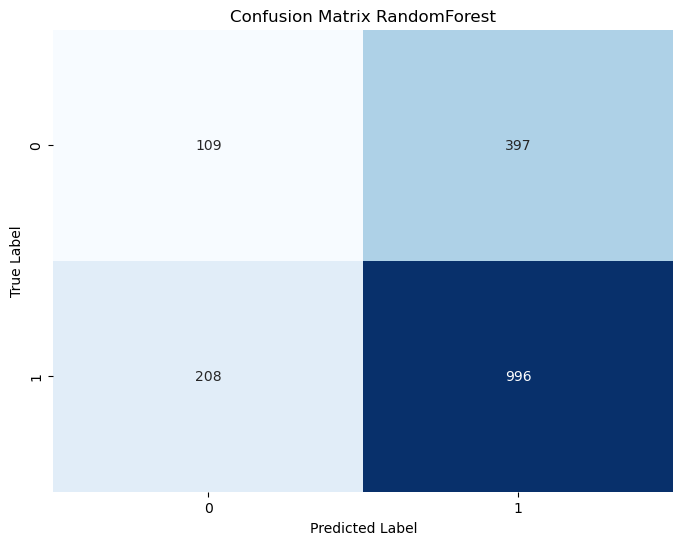


Training ...


c:\Users\user\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\user\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Train evaluation 

Evaluating ...
bad predictions :
                                                Sentence  Label  Predictions
11                                Sam cut himself free.      1            0
14           I've never known more of a man than Frank.      1            0
16                         Nora sent the book to Peter.      1            0
18    What it is certain that he was wearing is this...      1            0
20                      He will eat deep fried muffins.      1            0
...                                                 ...    ...          ...
9602                        few equipment is available.      0            1
9606  The secretary transcribed the record with the ...      0            1
9626                  The tree broke off some branches.      0            1
9627                                She was kissed him.      0            1
9629         The louder who talks, the angrier you get?      0            1

[1534 rows x 3 columns]
{'accurac

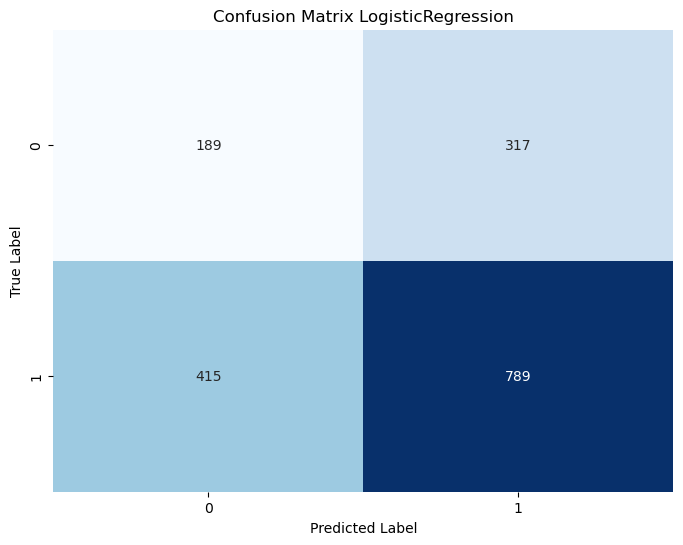


Training ...

Train evaluation 

Evaluating ...
bad predictions :
                                         Sentence  Label  Predictions
2                                   Who's there?      1            0
9                         The chicken was eaten.      1            0
11                         Sam cut himself free.      1            0
14    I've never known more of a man than Frank.      1            0
16                  Nora sent the book to Peter.      1            0
...                                          ...    ...          ...
9619                  She liked Moya's football.      0            1
9623                      Hunger fainted Sharon.      0            1
9626           The tree broke off some branches.      0            1
9627                         She was kissed him.      0            1
9629  The louder who talks, the angrier you get?      0            1

[2192 rows x 3 columns]
{'accuracy': 0.7723779854620976, 'recall': 0.7025960539979231, 'precision': 0.8

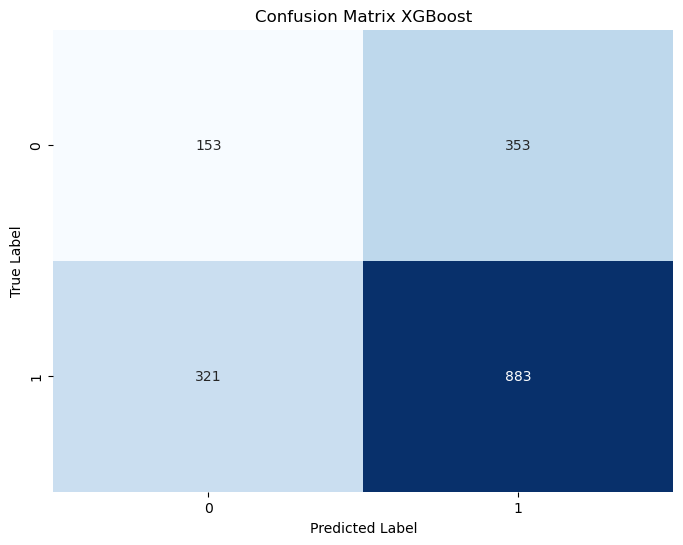


Training ...


c:\Users\user\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Train evaluation 

Evaluating ...
bad predictions :
                                                Sentence  Label  Predictions
2                                          Who's there?      1            0
16                         Nora sent the book to Peter.      1            0
18    What it is certain that he was wearing is this...      1            0
20                      He will eat deep fried muffins.      1            0
21    Paula spanked the naughty child with her right...      1            0
...                                                 ...    ...          ...
9572                        The dragons were slain all.      0            1
9589                 Mary is more than five feet short.      0            1
9595             Aphrodite quickly may free the animals      0            1
9623                             Hunger fainted Sharon.      0            1
9626                  The tree broke off some branches.      0            1

[882 rows x 3 columns]
{'accuracy

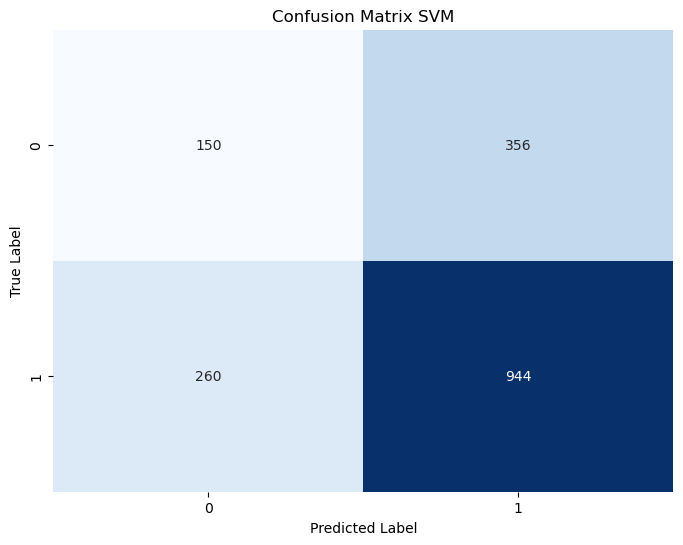

In [9]:
for classifier in ["RandomForest", "LogisticRegression", "XGBoost", "SVM"]:
    model = MLModel(classifier=classifier)

    # Train the model using the oversampled training data
    model.train(X_train, y_train)

    # Evaluate the model on the original training data
    print("\nTrain evaluation ")
    df_train_evaluation = model.evaluate(X_train, y_train)
    print(df_train_evaluation)

    # Evaluate the model on the test data
    evaluation = model.evaluate(X_test, y_test)
    print("classifier: ", classifier, evaluation)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(evaluation["confusion_matrix"], annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix '+classifier)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()


Meilleur modèle: Régression logistique

## 2. Modèle ML avec N-gram


Training ...
Vectorizer:  CountVectorizer(ngram_range=(1, 3))


c:\Users\user\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Train evaluation 

Evaluating ...
bad predictions :
                                                Sentence  Label  Predictions
163   The man standing over there's hat impressed me...      1            0
224        There is believed to be a sheep in the park.      1            0
362                         They can do it, can't they?      1            0
423                    Poseidon appears to own a dragon      1            0
536                         He's a reliable enough man.      1            0
1327  No student who scored 80 or more in the exam w...      1            0
1405  The knife that he threw into the sea had a gol...      1            0
1715  Bill reading Shakespeare and Maureen singing S...      1            0
1890  The stone knocked against the pole into the road.      1            0
2037                        They can't do it, can they?      1            0
2296  Bill's reading Shakespeare and Maureen's singi...      1            0
2717          The stone knocked th

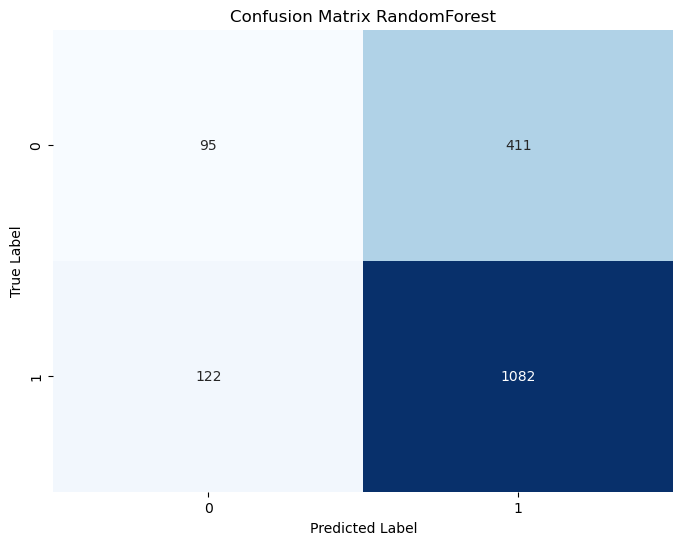


Training ...
Vectorizer:  CountVectorizer(ngram_range=(1, 3))


c:\Users\user\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\user\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Train evaluation 

Evaluating ...
bad predictions :
                                                Sentence  Label  Predictions
62                                         It may rain.      1            0
145      Because she's so pleasant, Mary I really like.      1            0
163   The man standing over there's hat impressed me...      1            0
224        There is believed to be a sheep in the park.      1            0
360                              Louis was sent a book.      1            0
...                                                 ...    ...          ...
8813                                         I praised.      0            1
8934       The committee hasn't yet made up their mind.      0            1
9039                               Pat handed to Chris.      0            1
9123                                         I praised.      0            1
9288         Two drops sanitize anything in your house.      0            1

[78 rows x 3 columns]
{'accuracy'

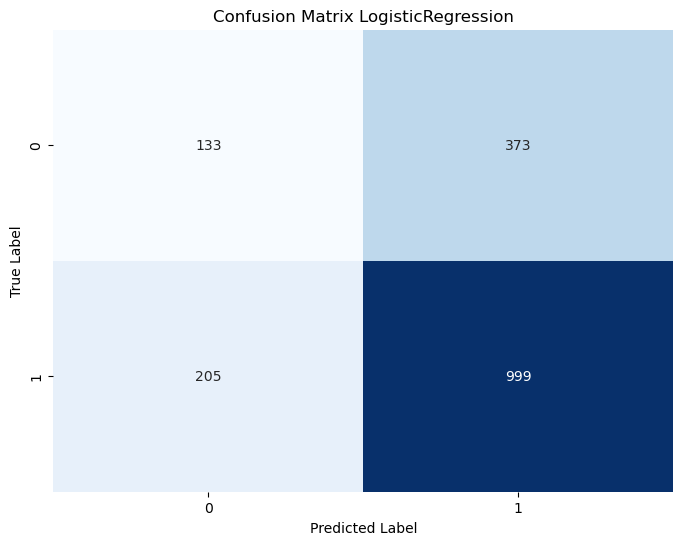


Training ...
Vectorizer:  CountVectorizer(ngram_range=(1, 3))

Train evaluation 

Evaluating ...
bad predictions :
                                                Sentence  Label  Predictions
11                                Sam cut himself free.      1            0
14           I've never known more of a man than Frank.      1            0
21    Paula spanked the naughty child with her right...      1            0
26                                    Bill gave me $40.      1            0
27                               only the student left.      1            0
...                                                 ...    ...          ...
9622                  That Jack ever slept is possible.      0            1
9623                             Hunger fainted Sharon.      0            1
9625                                 I do not be happy.      0            1
9626                  The tree broke off some branches.      0            1
9629         The louder who talks, the angrier 

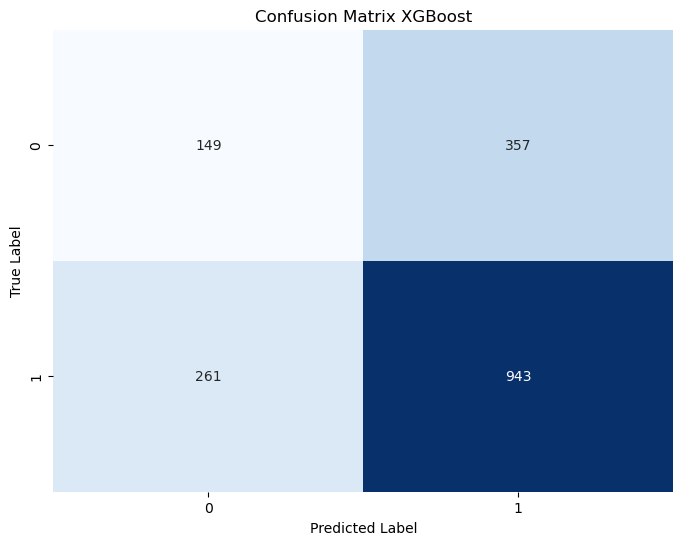


Training ...
Vectorizer:  CountVectorizer(ngram_range=(1, 3))


c:\Users\user\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Train evaluation 

Evaluating ...
bad predictions :
                                                Sentence  Label  Predictions
62                                         It may rain.      1            0
145      Because she's so pleasant, Mary I really like.      1            0
163   The man standing over there's hat impressed me...      1            0
181   Every woman standing under that tree is Mary's...      1            0
201                        I think John likes his beer.      1            0
...                                                 ...    ...          ...
9288         Two drops sanitize anything in your house.      0            1
9503                             The agency classified.      0            1
9507                                         Tessa cut.      0            1
9530                                 The package drove.      0            1
9559            Speaking not English is a disadvantage.      0            1

[274 rows x 3 columns]
{'accuracy

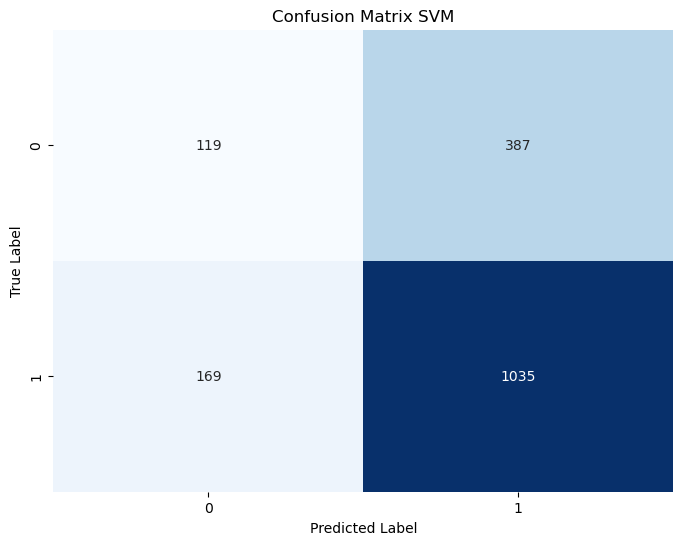

In [10]:
for classifier in ["RandomForest", "LogisticRegression", "XGBoost", "SVM"]:
    model = MLModelNGram(classifier=classifier)

    # Train the model using the oversampled training data
    model.train(X_train, y_train)

    # Evaluate the model on the original training data
    print("\nTrain evaluation ")
    df_train_evaluation = model.evaluate(X_train, y_train)
    print(df_train_evaluation)

    # Evaluate the model on the test data
    evaluation = model.evaluate(X_test, y_test)
    print("classifier: ", classifier, evaluation)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(evaluation["confusion_matrix"], annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix '+classifier)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

Meilleur modèle: XgBoost

## 3. Modèle ML avec étiquettes


Training ...
X_train_tags  [[('I', 'PRON'), ('will', 'AUX'), ('eat', 'VERB'), ('spaghetti', 'NOUN'), ('on', 'ADP'), ('Sunday', 'PROPN'), ('with', 'ADP'), ('Marco', 'PROPN'), ('.', 'PUNCT')], [('We', 'PRON'), ("'ll", 'AUX'), ('do', 'VERB'), ('it', 'PRON'), ('together', 'ADV'), (',', 'PUNCT'), ('you', 'PRON'), ('and', 'CCONJ'), ('I.', 'NOUN')], [('Who', 'PRON'), ("'s", 'AUX'), ('there', 'ADV'), ('?', 'PUNCT')], [('Fred', 'PROPN'), ('will', 'AUX'), ('warn', 'VERB'), ('Martha', 'PROPN'), ('that', 'SCONJ'), ('she', 'PRON'), ('should', 'AUX'), ('claim', 'VERB'), ('that', 'SCONJ'), ('her', 'PRON'), ('brother', 'NOUN'), ('is', 'AUX'), ('patriotic', 'ADJ'), ('.', 'PUNCT')], [('Have', 'AUX'), ('they', 'PRON'), ('left', 'VERB'), ('?', 'PUNCT')], [('How', 'SCONJ'), ('many', 'ADJ'), ('did', 'AUX'), ('you', 'PRON'), ('buy', 'VERB'), ('of', 'ADP'), ('those', 'DET'), ('pies', 'NOUN'), ('at', 'ADP'), ('the', 'DET'), ('fair', 'NOUN'), ('?', 'PUNCT')], [('I', 'PRON'), ('would', 'AUX'), ('prefer', 'VERB'

c:\Users\user\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Train evaluation 

Evaluating ...
bad predictions :
                                                Sentence  Label  Predictions  \
2                                          Who's there?      1            0   
13                                    They have no car.      1            0   
14           I've never known more of a man than Frank.      1            0   
16                         Nora sent the book to Peter.      1            0   
19                                  You married no one.      1            0   
...                                                 ...    ...          ...   
9574             Doug removed the scratches to nowhere.      0            1   
9606  The secretary transcribed the record with the ...      0            1   
9609     He's enough of the coward to pull the trigger.      0            1   
9613                       What time did you arrive at?      0            1   
9626                  The tree broke off some branches.      0            1  

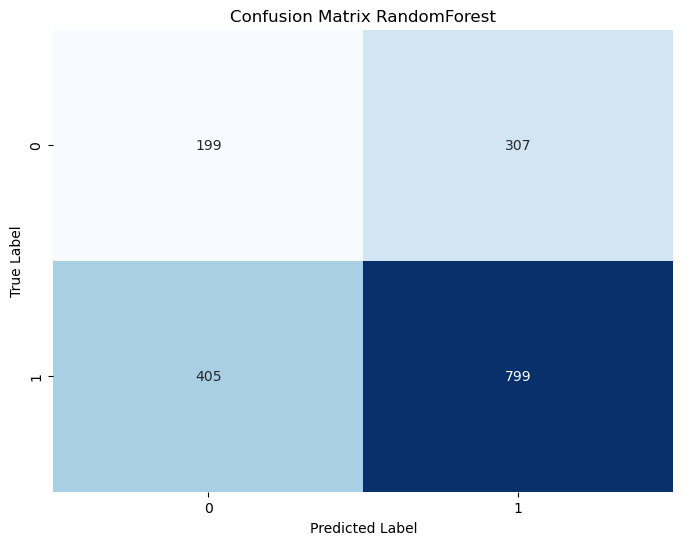


Training ...
X_train_tags  [[('I', 'PRON'), ('will', 'AUX'), ('eat', 'VERB'), ('spaghetti', 'NOUN'), ('on', 'ADP'), ('Sunday', 'PROPN'), ('with', 'ADP'), ('Marco', 'PROPN'), ('.', 'PUNCT')], [('We', 'PRON'), ("'ll", 'AUX'), ('do', 'VERB'), ('it', 'PRON'), ('together', 'ADV'), (',', 'PUNCT'), ('you', 'PRON'), ('and', 'CCONJ'), ('I.', 'NOUN')], [('Who', 'PRON'), ("'s", 'AUX'), ('there', 'ADV'), ('?', 'PUNCT')], [('Fred', 'PROPN'), ('will', 'AUX'), ('warn', 'VERB'), ('Martha', 'PROPN'), ('that', 'SCONJ'), ('she', 'PRON'), ('should', 'AUX'), ('claim', 'VERB'), ('that', 'SCONJ'), ('her', 'PRON'), ('brother', 'NOUN'), ('is', 'AUX'), ('patriotic', 'ADJ'), ('.', 'PUNCT')], [('Have', 'AUX'), ('they', 'PRON'), ('left', 'VERB'), ('?', 'PUNCT')], [('How', 'SCONJ'), ('many', 'ADJ'), ('did', 'AUX'), ('you', 'PRON'), ('buy', 'VERB'), ('of', 'ADP'), ('those', 'DET'), ('pies', 'NOUN'), ('at', 'ADP'), ('the', 'DET'), ('fair', 'NOUN'), ('?', 'PUNCT')], [('I', 'PRON'), ('would', 'AUX'), ('prefer', 'VERB'

c:\Users\user\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


bad predictions :
                                                Sentence  Label  Predictions  \
1                      We'll do it together, you and I.      1            0   
2                                          Who's there?      1            0   
3     Fred will warn Martha that she should claim th...      1            0   
5       How many did you buy of those pies at the fair?      1            0   
6          I would prefer for John to be the candidate.      1            0   
...                                                 ...    ...          ...   
9618  This girl in the red coat will put a picture o...      0            1   
9622                  That Jack ever slept is possible.      0            1   
9623                             Hunger fainted Sharon.      0            1   
9624           Who does Phineas know a girl jealous of?      0            1   
9626                  The tree broke off some branches.      0            1   

                                

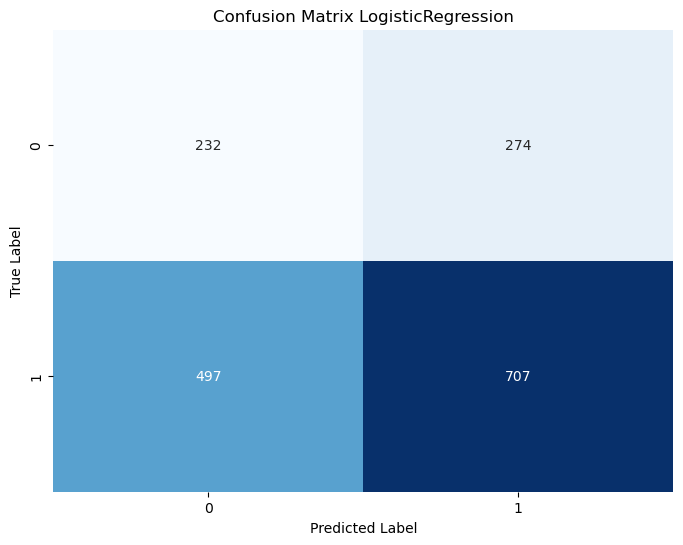


Training ...
X_train_tags  [[('I', 'PRON'), ('will', 'AUX'), ('eat', 'VERB'), ('spaghetti', 'NOUN'), ('on', 'ADP'), ('Sunday', 'PROPN'), ('with', 'ADP'), ('Marco', 'PROPN'), ('.', 'PUNCT')], [('We', 'PRON'), ("'ll", 'AUX'), ('do', 'VERB'), ('it', 'PRON'), ('together', 'ADV'), (',', 'PUNCT'), ('you', 'PRON'), ('and', 'CCONJ'), ('I.', 'NOUN')], [('Who', 'PRON'), ("'s", 'AUX'), ('there', 'ADV'), ('?', 'PUNCT')], [('Fred', 'PROPN'), ('will', 'AUX'), ('warn', 'VERB'), ('Martha', 'PROPN'), ('that', 'SCONJ'), ('she', 'PRON'), ('should', 'AUX'), ('claim', 'VERB'), ('that', 'SCONJ'), ('her', 'PRON'), ('brother', 'NOUN'), ('is', 'AUX'), ('patriotic', 'ADJ'), ('.', 'PUNCT')], [('Have', 'AUX'), ('they', 'PRON'), ('left', 'VERB'), ('?', 'PUNCT')], [('How', 'SCONJ'), ('many', 'ADJ'), ('did', 'AUX'), ('you', 'PRON'), ('buy', 'VERB'), ('of', 'ADP'), ('those', 'DET'), ('pies', 'NOUN'), ('at', 'ADP'), ('the', 'DET'), ('fair', 'NOUN'), ('?', 'PUNCT')], [('I', 'PRON'), ('would', 'AUX'), ('prefer', 'VERB'

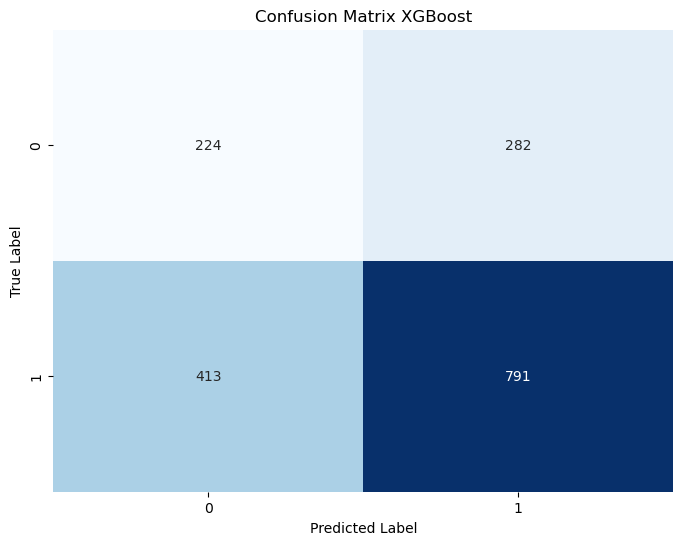


Training ...
X_train_tags  [[('I', 'PRON'), ('will', 'AUX'), ('eat', 'VERB'), ('spaghetti', 'NOUN'), ('on', 'ADP'), ('Sunday', 'PROPN'), ('with', 'ADP'), ('Marco', 'PROPN'), ('.', 'PUNCT')], [('We', 'PRON'), ("'ll", 'AUX'), ('do', 'VERB'), ('it', 'PRON'), ('together', 'ADV'), (',', 'PUNCT'), ('you', 'PRON'), ('and', 'CCONJ'), ('I.', 'NOUN')], [('Who', 'PRON'), ("'s", 'AUX'), ('there', 'ADV'), ('?', 'PUNCT')], [('Fred', 'PROPN'), ('will', 'AUX'), ('warn', 'VERB'), ('Martha', 'PROPN'), ('that', 'SCONJ'), ('she', 'PRON'), ('should', 'AUX'), ('claim', 'VERB'), ('that', 'SCONJ'), ('her', 'PRON'), ('brother', 'NOUN'), ('is', 'AUX'), ('patriotic', 'ADJ'), ('.', 'PUNCT')], [('Have', 'AUX'), ('they', 'PRON'), ('left', 'VERB'), ('?', 'PUNCT')], [('How', 'SCONJ'), ('many', 'ADJ'), ('did', 'AUX'), ('you', 'PRON'), ('buy', 'VERB'), ('of', 'ADP'), ('those', 'DET'), ('pies', 'NOUN'), ('at', 'ADP'), ('the', 'DET'), ('fair', 'NOUN'), ('?', 'PUNCT')], [('I', 'PRON'), ('would', 'AUX'), ('prefer', 'VERB'

c:\Users\user\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Train evaluation 

Evaluating ...
bad predictions :
                                                Sentence  Label  Predictions  \
0            I will eat spaghetti on Sunday with Marco.      1            0   
2                                          Who's there?      1            0   
3     Fred will warn Martha that she should claim th...      1            0   
4                                       Have they left?      1            0   
11                                Sam cut himself free.      1            0   
...                                                 ...    ...          ...   
9622                  That Jack ever slept is possible.      0            1   
9623                             Hunger fainted Sharon.      0            1   
9624           Who does Phineas know a girl jealous of?      0            1   
9626                  The tree broke off some branches.      0            1   
9628                  We caught them eaten the bananas.      0            1  

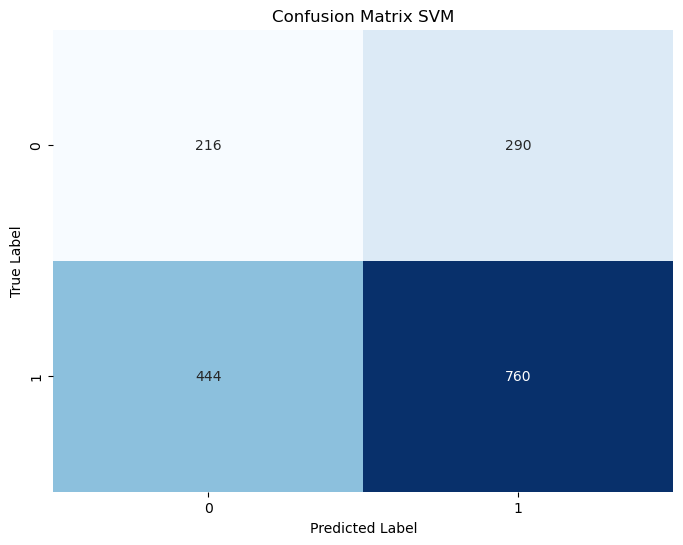

In [11]:
for classifier in ["RandomForest", "LogisticRegression", "XGBoost", "SVM"]:
    model = MLModelPosTag(classifier=classifier)

    # Train the model using the oversampled training data
    model.train(X_train, y_train)

    # Evaluate the model on the original training data
    print("\nTrain evaluation ")
    df_train_evaluation = model.evaluate(X_train, y_train)
    print(df_train_evaluation)

    # Evaluate the model on the test data
    evaluation = model.evaluate(X_test, y_test)
    print("classifier: ", classifier, evaluation)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(evaluation["confusion_matrix"], annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix '+classifier)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

Meilleur modèle: Régression logistique

## 4. Modèle avec recomposition de phrase


Training ...


c:\Users\user\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Train evaluation 

Evaluating ...
bad predictions :
                                                Sentence  Label  Predictions  \
9                                The chicken was eaten.      1            0   
20                      He will eat deep fried muffins.      1            0   
28                           Flora cooks gourmet meals.      1            0   
30                          Anne astonished her father.      1            0   
33            They pushed the prisoners into the truck.      1            0   
...                                                 ...    ...          ...   
9596                             The rail holds easily.      0            1   
9606  The secretary transcribed the record with the ...      0            1   
9622                  That Jack ever slept is possible.      0            1   
9626                  The tree broke off some branches.      0            1   
9628                  We caught them eaten the bananas.      0            1  

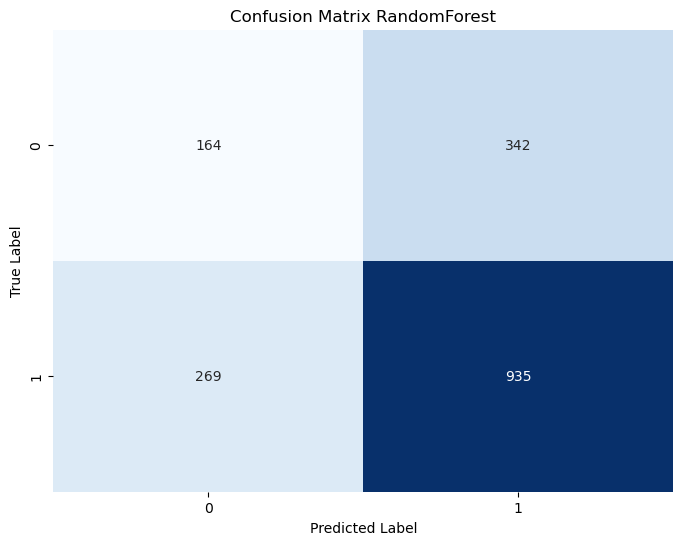


Training ...


c:\Users\user\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\user\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Train evaluation 

Evaluating ...
bad predictions :
                                              Sentence  Label  Predictions  \
5     How many did you buy of those pies at the fair?      1            0   
6        I would prefer for John to be the candidate.      1            0   
10                        Audrey tiptoed to the door.      1            0   
12              Imogen took the vase to her mother's.      1            0   
17               John's bike got fixed or got stolen.      1            0   
...                                               ...    ...          ...   
9608              the bottle drained the liquid free.      0            1   
9615            Mira condemned the accident on Terry.      0            1   
9617                     This doll is hard to see it.      0            1   
9625                               I do not be happy.      0            1   
9628                We caught them eaten the bananas.      0            1   

                     

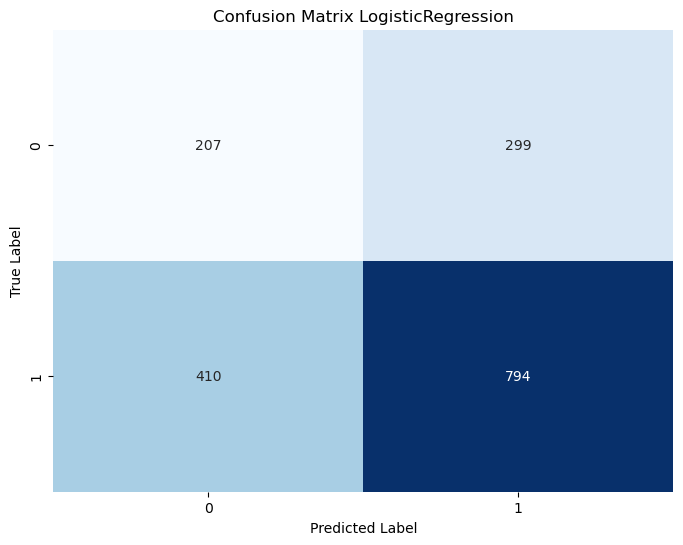


Training ...

Train evaluation 

Evaluating ...
bad predictions :
                                                Sentence  Label  Predictions  \
2                                          Who's there?      1            0   
6          I would prefer for John to be the candidate.      1            0   
12                Imogen took the vase to her mother's.      1            0   
17                 John's bike got fixed or got stolen.      1            0   
20                      He will eat deep fried muffins.      1            0   
...                                                 ...    ...          ...   
9606  The secretary transcribed the record with the ...      0            1   
9615              Mira condemned the accident on Terry.      0            1   
9619                         She liked Moya's football.      0            1   
9622                  That Jack ever slept is possible.      0            1   
9628                  We caught them eaten the bananas.      0 

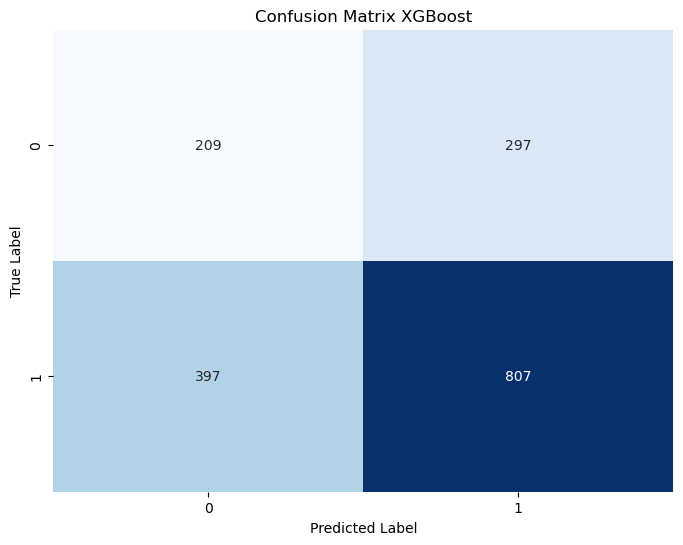


Training ...


c:\Users\user\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Train evaluation 

Evaluating ...
bad predictions :
                                           Sentence  Label  Predictions  \
4                                  Have they left?      1            0   
6     I would prefer for John to be the candidate.      1            0   
10                     Audrey tiptoed to the door.      1            0   
12           Imogen took the vase to her mother's.      1            0   
20                 He will eat deep fried muffins.      1            0   
...                                            ...    ...          ...   
9615         Mira condemned the accident on Terry.      0            1   
9619                    She liked Moya's football.      0            1   
9622             That Jack ever slept is possible.      0            1   
9625                            I do not be happy.      0            1   
9628             We caught them eaten the bananas.      0            1   

                                          Sentence_tags  

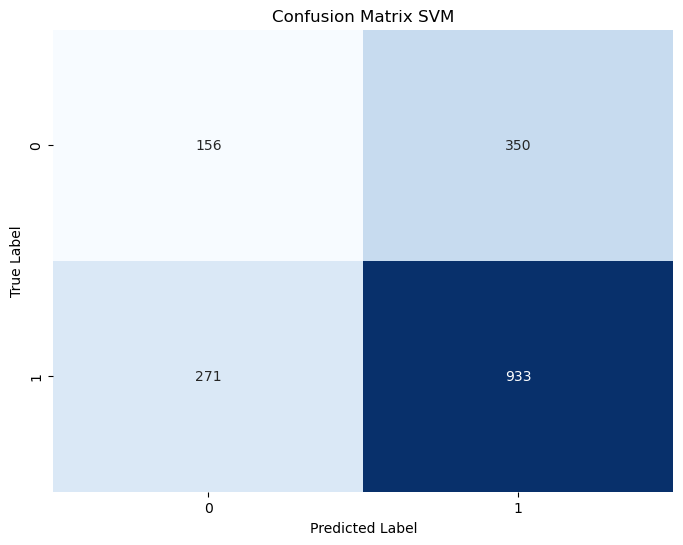

In [12]:
for classifier in ["RandomForest", "LogisticRegression", "XGBoost", "SVM"]:
    model = MLModelSentenceRecomposition(classifier=classifier)

    # Train the model using the oversampled training data
    model.train(X_train, y_train)

    # Evaluate the model on the original training data
    print("\nTrain evaluation ")
    df_train_evaluation = model.evaluate(X_train, y_train)
    print(df_train_evaluation)

    # Evaluate the model on the test data
    evaluation = model.evaluate(X_test, y_test)
    print("classifier: ", classifier, evaluation)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(evaluation["confusion_matrix"], annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix '+classifier)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

Meilleur modèle: XgBoost